In [ ]:
!pip install transformers torch pandas scikit-learn scipy
!pip install detoxify
!huggingface-cli download unitary/unbiased-toxic-roberta


⚠️  Warning: 'huggingface-cli download' is deprecated. Use 'hf download' instead.
Fetching 9 files:   0% 0/9 [00:00<?, ?it/s]Downloading 'merges.txt' to '/root/.cache/huggingface/hub/models--unitary--unbiased-toxic-roberta/blobs/226b0752cac7789c48f0cb3ec53eda48b7be36cc.incomplete'

merges.txt: 0.00B [00:00, ?B/s]

config.json: 1.38kB [00:00, 4.29MB/s]
Download complete. Moving file to /root/.cache/huggingface/hub/models--unitary--unbiased-toxic-roberta/blobs/809ed6007ce0ef30d9e989dc8413c548800af478


special_tokens_map.json: 100% 772/772 [00:00<00:00, 8.50MB/s]


tokenizer_config.json: 100% 997/997 [00:00<00:00, 12.7MB/s]
Download complete. Moving file to /root/.cache/huggingface/hub/models--unitary--unbiased-toxic-roberta/blobs/8df27364ff6d1c31eafe1ec8cce6d372e6b34c59
Download complete. Moving file to /root/.cache/huggingface/hub/models--unitary--unbiased-toxic-roberta/blobs/e97d1993365bb21c88f390e8703e4c1af564821f
merges.txt: 456kB [00:00, 6.03MB/s]
Download complete. Moving file to 

In [ ]:
# ==========================================
# 1) UPLOAD DATASET
# ==========================================

import pandas as pd
import numpy as np
import torch
from detoxify import Detoxify
from tqdm import tqdm
from sklearn.metrics import (
    f1_score, precision_score, recall_score,
    accuracy_score, classification_report
)

DATASET_PATH = "balanced_gender_only.csv"
DATASET_TYPE = "gender"

IDENTITY_COLUMNS = {
    "gender": ["male", "female", "transgender", "other_gender"],
    "race": ["asian", "black", "latino", "white", "other_race_or_ethnicity"]
}

print(f"Dataset loaded: {DATASET_PATH}")
df = pd.read_csv(DATASET_PATH)
identity_columns = IDENTITY_COLUMNS["gender"]


Dataset loaded: balanced_gender_only.csv


In [ ]:

# ==========================================
# 2) FAST DETOXIFY — FORCED GPU + PROGRESS BAR
# ==========================================
from sklearn.metrics import confusion_matrix
assert torch.cuda.is_available(), "GPU not available — enable GPU runtime."

device = torch.device("cuda")
print("GPU:", torch.cuda.get_device_name(0))

# Load Detoxify on GPU
model = Detoxify("original", device="cuda")

comments = df["comment_text"].fillna("").tolist()
BATCH_SIZE = 64

toxicity_scores = []
predictions = []

print("\nRunning Detoxify with GPU batching + progress bar...\n")

for i in tqdm(range(0, len(comments), BATCH_SIZE), desc="Detoxify Inference", unit="batch"):

    batch = comments[i:i+BATCH_SIZE]

    try:
        with torch.no_grad():
            results = model.predict(batch)

        scores = results["toxicity"]
        toxicity_scores.extend(scores)
        predictions.extend([1 if s > 0.5 else 0 for s in scores])

    except RuntimeError as e:
        print("⚠️ CUDA error — recovering:", e)
        torch.cuda.empty_cache()
        torch.cuda.synchronize()

        with torch.no_grad():
            results = model.predict(batch)

        scores = results["toxicity"]
        toxicity_scores.extend(scores)
        predictions.extend([1 if s > 0.5 else 0 for s in scores])

    # Prevent GPU fallback
    torch.cuda.empty_cache()

    if next(model.model.parameters()).device.type != "cuda":
        raise RuntimeError("🚨 Detoxify fell back to CPU — stopping run.")

print("\n✓ Fast Detoxify inference completed!\n")

df["detoxify_toxicity_score"] = toxicity_scores
df["detoxify_prediction"] = predictions
df["human_label"] = (df["target"] >= 0.5).astype(int)


# ==========================================
# 3) OVERALL METRICS
# ==========================================
print("===== OVERALL PERFORMANCE =====")

f1_overall = f1_score(df['human_label'], df['detoxify_prediction'])
precision_overall = precision_score(df['human_label'], df['detoxify_prediction'])
recall_overall = recall_score(df['human_label'], df['detoxify_prediction'])
accuracy_overall = accuracy_score(df['human_label'], df['detoxify_prediction'])

non_toxic = df[df['human_label'] == 0]
fpr_overall = (non_toxic['detoxify_prediction'] == 1).sum() / len(non_toxic)

print(f"""
F1 Score:  {f1_overall:.4f}
Precision: {precision_overall:.4f}
Recall:    {recall_overall:.4f}
Accuracy:  {accuracy_overall:.4f}
FPR:       {fpr_overall:.4f}

Classification Report:
{classification_report(df['human_label'], df['detoxify_prediction'], target_names=['Non-Toxic', 'Toxic'])}
""")


print("\n====================================")
print("Identity Bias Analysis (Detoxify)")
print("====================================")

results = []

for identity in identity_columns:
    subset = df[df[identity] > 0]

    if len(subset) == 0:
        continue

    # Confusion matrix
    tn, fp, fn, tp = confusion_matrix(
        subset["human_label"],
        subset["detoxify_prediction"],
        labels=[0, 1]
    ).ravel()

    id_precision = precision_score(subset["human_label"], subset["detoxify_prediction"], zero_division=0)
    id_recall = recall_score(subset["human_label"], subset["detoxify_prediction"], zero_division=0)
    id_f1 = f1_score(subset["human_label"], subset["detoxify_prediction"], zero_division=0)
    id_accuracy = (tp + tn) / (tp + tn + fp + fn) if (tp+tn+fp+fn) else 0
    fpr = fp / (fp + tn) if (fp + tn) else 0

    results.append({
        "Identity": identity,
        "Count": len(subset),
        "Precision": id_precision,
        "Recall": id_recall,
        "F1": id_f1,
        "Accuracy": id_accuracy,
        "FPR": fpr
    })

    print(f"""
{identity.upper()}
Count: {len(subset)}
Precision: {id_precision:.4f}
Recall: {id_recall:.4f}
F1 Score: {id_f1:.4f}
Accuracy: {id_accuracy:.4f}
FPR: {fpr:.4f}
""")

bias_df = pd.DataFrame(results)



# ==========================================
# 5) FALSE POSITIVES
# ==========================================
has_identity = df[identity_columns].sum(axis=1) > 0
false_pos = df[
    (df["human_label"] == 0) &
    (df["detoxify_prediction"] == 1) &
    has_identity
]

print(f"\nTotal false positives: {len(false_pos)}")
print(f"Out of identity comments: {has_identity.sum()}")
print(f"Rate: {(len(false_pos)/has_identity.sum())*100:.2f}%\n")

print("\nTop 5 False Positives:\n")
for idx, (_, row) in enumerate(false_pos.head(5).iterrows()):
    print(f"{idx+1}. Score={row['detoxify_toxicity_score']:.4f}")
    print(f"   Comment: {row['comment_text'][:150]}...")
    print(f"   Identities: {[idc for idc in identity_columns if row[idc] > 0]}")
    print()


# ==========================================
# 6) SAVE CSV RESULTS
# ==========================================
bias_df.to_csv("detoxify_race_metrics_by_identity.csv", index=False)
false_pos.to_csv("detoxify_race_false_positives_detailed.csv", index=False)

print("\n✓ Saved:")
print("  detoxify_race_metrics_by_identity.csv")
print("  detoxify_race_false_positives_detailed.csv")


GPU: NVIDIA A100-SXM4-80GB

Running Detoxify with GPU batching + progress bar...



Detoxify Inference: 100%|██████████| 171/171 [00:45<00:00,  3.76batch/s]


✓ Fast Detoxify inference completed!

===== OVERALL PERFORMANCE =====

F1 Score:  0.4710
Precision: 0.6622
Recall:    0.3655
Accuracy:  0.8686
FPR:       0.0355

Classification Report:
              precision    recall  f1-score   support

   Non-Toxic       0.89      0.96      0.92      9149
       Toxic       0.66      0.37      0.47      1743

    accuracy                           0.87     10892
   macro avg       0.78      0.66      0.70     10892
weighted avg       0.85      0.87      0.85     10892



Identity Bias Analysis (Detoxify)

MALE
Count: 5713
Precision: 0.6640
Recall: 0.3603
F1 Score: 0.4672
Accuracy: 0.8650
FPR: 0.0358


FEMALE
Count: 5437
Precision: 0.6494
Recall: 0.3590
F1 Score: 0.4624
Accuracy: 0.8606
FPR: 0.0389


TRANSGENDER
Count: 3196
Precision: 0.6621
Recall: 0.3217
F1 Score: 0.4330
Accuracy: 0.8411
FPR: 0.0382


OTHER_GENDER
Count: 2933
Precision: 0.7000
Recall: 0.3313
F1 Score: 0.4497
Accuracy: 0.8657
FPR: 0.0282


Total false positives: 325
Out of identit

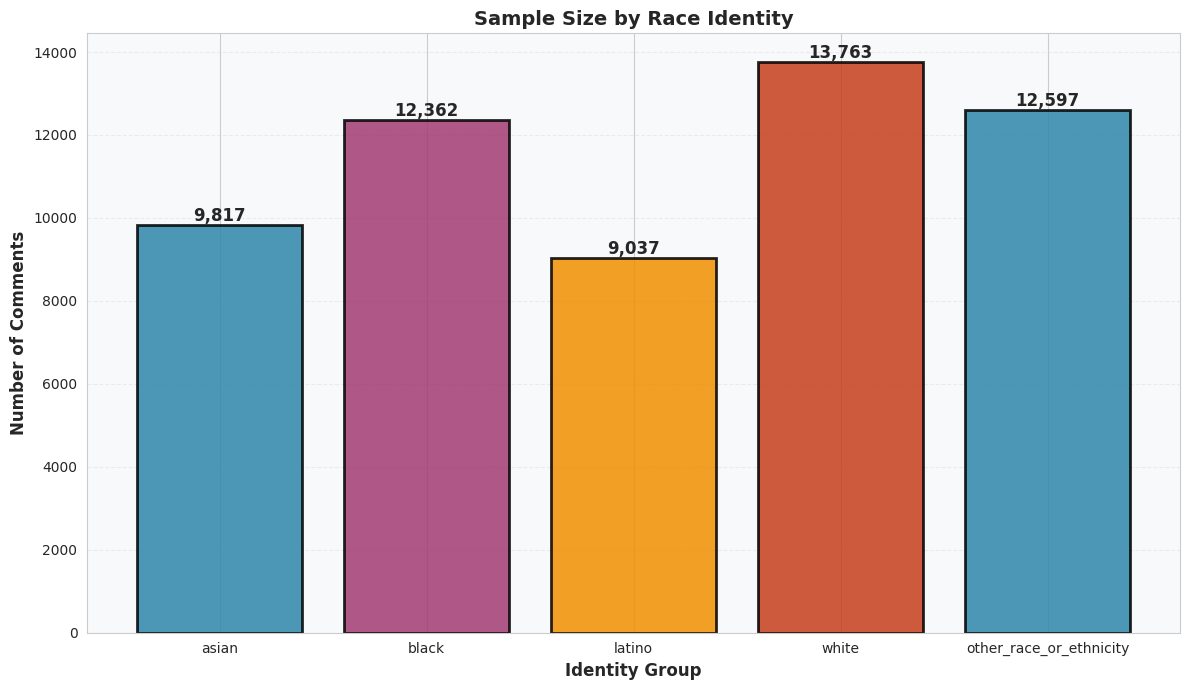

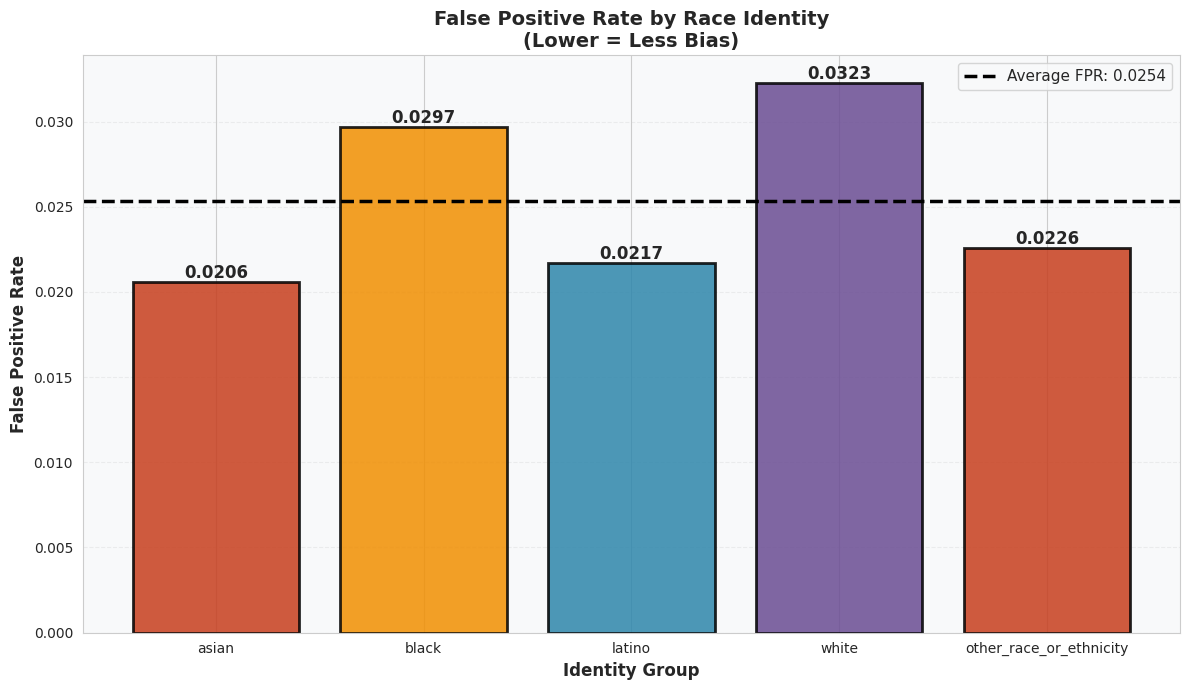

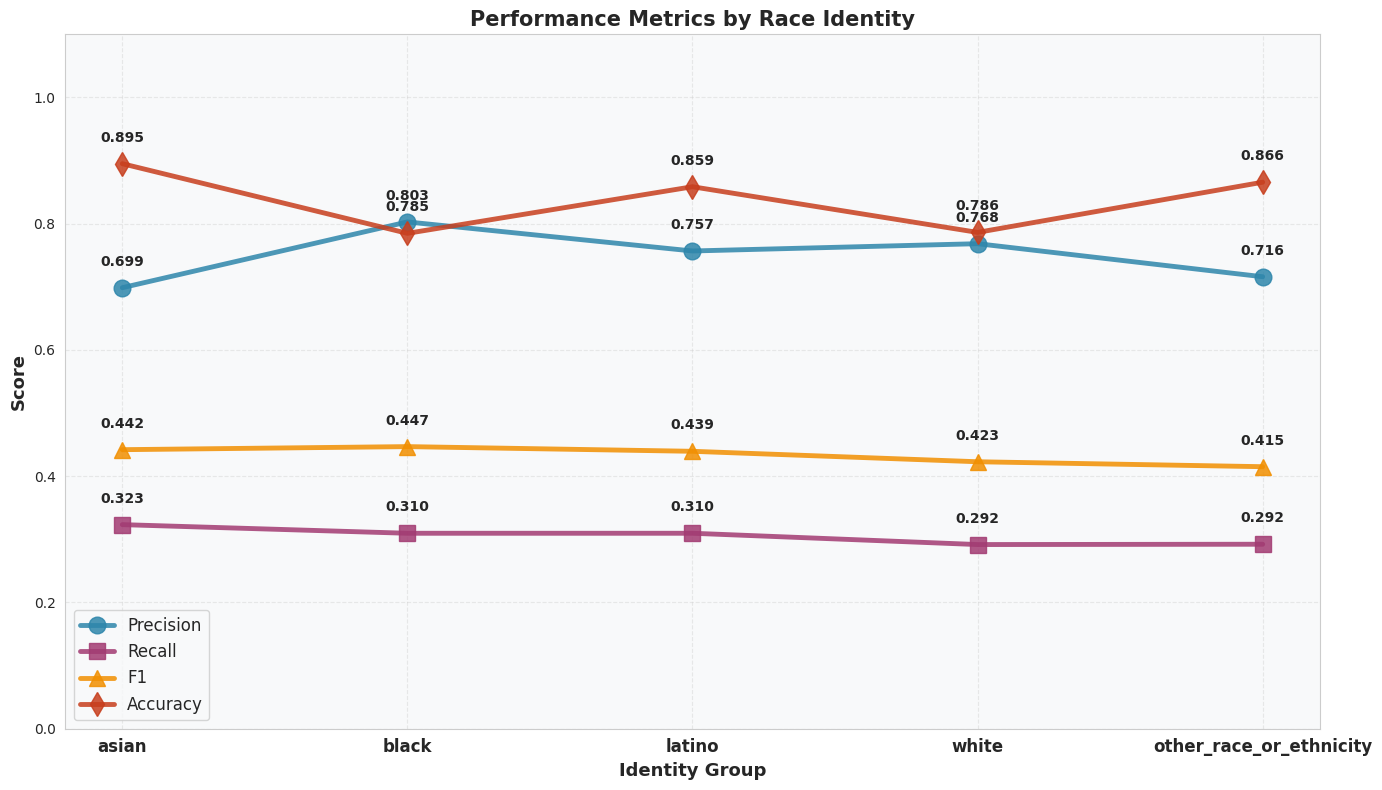


SUMMARY - RACE DATASET

                Identity  Count  Precision   Recall       F1  Accuracy  False_Positive_Rate
                  asian  9,817   0.698630 0.323296 0.442037  0.895080             0.020573
                  black 12,362   0.802838 0.309620 0.446893  0.784744             0.029696
                 latino  9,037   0.756798 0.309642 0.439474  0.858581             0.021701
                  white 13,763   0.768354 0.291746 0.422911  0.786238             0.032280
other_race_or_ethnicity 12,597   0.715990 0.292255 0.415081  0.865762             0.022572

✓ Visualizations saved:
  - detoxify_race_sample_size.png
  - detoxify_race_fpr_by_identity.png
  - detoxify_race_metrics_line.png


In [ ]:
# ==========================================
# GRAPH + SUMMARY VISUALIZATION (RACE)
# ==========================================

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Define dataset type again for safety
DATASET_TYPE = "race"

# Load generated identity metrics
bias_df = pd.read_csv(f"detoxify_{DATASET_TYPE}_metrics_by_identity.csv")

# Set plot style
sns.set_style("whitegrid")
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = '#f8f9fa'


# ==========================================
# 1) SAMPLE SIZE BAR CHART
# ==========================================
fig, ax = plt.subplots(figsize=(12, 7))
colors_sample = ['#2E86AB', '#A23B72', '#F18F01', '#C73E1D']

bars = ax.bar(
    bias_df['Identity'], bias_df['Count'],
    color=colors_sample, alpha=0.85,
    edgecolor='black', linewidth=2
)

for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height):,}',
            ha='center', va='bottom', fontsize=12, fontweight='bold')

ax.set_ylabel('Number of Comments', fontweight='bold', fontsize=12)
ax.set_xlabel('Identity Group', fontweight='bold', fontsize=12)
ax.set_title(f'Sample Size by {DATASET_TYPE.capitalize()} Identity', fontweight='bold', fontsize=14)
ax.grid(axis='y', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.savefig(f'detoxify_{DATASET_TYPE}_sample_size.png', dpi=300, bbox_inches='tight')
plt.show()


# ==========================================
# 2) FALSE POSITIVE RATE BAR CHART
# ==========================================
fig, ax = plt.subplots(figsize=(12, 7))

colors_fpr = ['#C73E1D', '#F18F01', '#2E86AB', '#6A4C93']
bars = ax.bar(
    bias_df['Identity'], bias_df['False_Positive_Rate'],
    color=colors_fpr, alpha=0.85,
    edgecolor='black', linewidth=2
)

for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.4f}',
            ha='center', va='bottom', fontsize=12, fontweight='bold')

overall_fpr = bias_df['False_Positive_Rate'].mean()
ax.axhline(overall_fpr, color='black', linestyle='--', linewidth=2.5,
           label=f'Average FPR: {overall_fpr:.4f}')

ax.set_ylabel('False Positive Rate', fontweight='bold', fontsize=12)
ax.set_xlabel('Identity Group', fontweight='bold', fontsize=12)
ax.set_title(f'False Positive Rate by {DATASET_TYPE.capitalize()} Identity\n(Lower = Less Bias)', fontweight='bold', fontsize=14)
ax.legend(fontsize=11)
ax.grid(axis='y', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.savefig(f'detoxify_{DATASET_TYPE}_fpr_by_identity.png', dpi=300, bbox_inches='tight')
plt.show()


# ==========================================
# 3) LINE PLOT OF METRICS
# ==========================================
fig, ax = plt.subplots(figsize=(14, 8))

metrics_plot = ['Precision', 'Recall', 'F1', 'Accuracy']
colors_lines = ['#2E86AB', '#A23B72', '#F18F01', '#C73E1D']
markers = ['o', 's', '^', 'd']
x_pos = np.arange(len(bias_df))

for i, metric in enumerate(metrics_plot):
    ax.plot(x_pos, bias_df[metric],
            marker=markers[i], markersize=12,
            linewidth=3.5, label=metric,
            color=colors_lines[i], alpha=0.85)

    for j, val in enumerate(bias_df[metric]):
        ax.text(j, val + 0.03, f"{val:.3f}",
                ha='center', va='bottom',
                fontsize=10, fontweight='bold')

ax.set_xticks(x_pos)
ax.set_xticklabels(bias_df['Identity'], fontsize=12, fontweight='bold')
ax.set_ylabel('Score', fontweight='bold', fontsize=13)
ax.set_xlabel('Identity Group', fontweight='bold', fontsize=13)
ax.set_title(f'Performance Metrics by {DATASET_TYPE.capitalize()} Identity',
             fontweight='bold', fontsize=15)

ax.legend(fontsize=12)
ax.set_ylim(0.0, 1.1)
ax.grid(True, alpha=0.4, linestyle='--')

plt.tight_layout()
plt.savefig(f'detoxify_{DATASET_TYPE}_metrics_line.png', dpi=300, bbox_inches='tight')
plt.show()


# ==========================================
# 4) SUMMARY TABLE PRINT
# ==========================================
print("\n" + "="*80)
print(f"SUMMARY - {DATASET_TYPE.upper()} DATASET")
print("="*80)

summary_table = bias_df[['Identity', 'Count', 'Precision', 'Recall', 'F1', 'Accuracy', 'False_Positive_Rate']].copy()
summary_table['Count'] = summary_table['Count'].apply(lambda x: f"{int(x):,}")

print("\n", summary_table.to_string(index=False))

print(f"\n✓ Visualizations saved:")
print(f"  - detoxify_{DATASET_TYPE}_sample_size.png")
print(f"  - detoxify_{DATASET_TYPE}_fpr_by_identity.png")
print(f"  - detoxify_{DATASET_TYPE}_metrics_line.png")
